# Class imbalance learning by MNIST

## 1. Classification

In [1]:
from ncc.models import Model2D
from ncc.history import save_history
from ncc.preprocessing import preprocess_input
from ncc.metrics import show_matrix

import tensorflow as tf
import keras.backend as K
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, Lambda

from imblearn.under_sampling import RandomUnderSampler

import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

Using TensorFlow backend.


In [2]:
# Parameters
num_classes = 10
input_shape = (28, 28, 1)
epochs = 2
batch_size = 128

(array([5923., 6742., 5958., 6131., 5842., 5421., 5918., 6265., 5851.,
          49.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

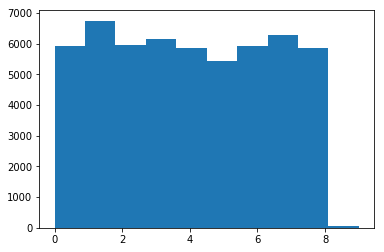

In [67]:
# Prepare data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Cut label 9
sorted_idx = np.argsort(y_train, axis=0)
x_train = x_train[sorted_idx][:-5900]
y_train = y_train[sorted_idx][:-5900]

# Shuffle
p = np.random.permutation(len(x_train))
x_train = x_train[p]
y_train = y_train[p]

# Number of each labels
num_labels = []
label_list = list(y_train)
for i in range(num_classes):
    count = label_list.count(i)
    num_labels.append(count)

# Show histogram
plt.hist(y_train) 

In [4]:
# Preprocess
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)
x_train, y_train = preprocess_input(x_train, y_train)
x_test, y_test = preprocess_input(x_test, y_test)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(54100, 28, 28, 1) (54100, 10) (10000, 28, 28, 1) (10000, 10)


## 1-1. Usual Training

In [5]:
# Build and train model
model = Model2D(input_shape=input_shape, num_classes=num_classes)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size)

Train on 54100 samples, validate on 10000 samples
Epoch 1/2
54100/54100 [==============================] - 10s 192us/step - loss: 0.2926 - acc: 0.9105 - val_loss: 0.3764 - val_acc: 0.8846
Epoch 2/2
54100/54100 [==============================] - 8s 155us/step - loss: 0.0992 - acc: 0.9688 - val_loss: 0.3463 - val_acc: 0.8952


Confusion matrix, without normalization
[[ 976    0    0    0    0    0    2    1    1    0]
 [   0 1129    3    0    0    0    2    1    0    0]
 [   4    0 1022    0    1    0    0    4    1    0]
 [   0    0    7  989    0    5    0    5    4    0]
 [   0    0    0    0  977    0    2    2    1    0]
 [   2    1    0    4    0  879    2    3    1    0]
 [   5    2    0    0    1    4  943    0    3    0]
 [   0    2   10    1    0    0    0 1014    1    0]
 [   6    0    7    2    1    2    2    9  944    1]
 [  10    6    8   13  243   36    0  597   17   79]]
Normalized confusion matrix


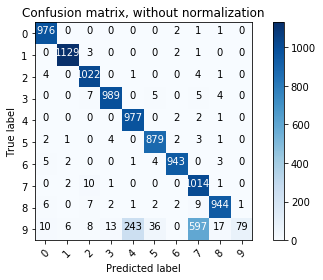

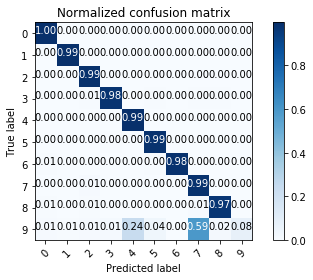

In [6]:
# Show confusion matrix
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)  # from one hot to class index
y_true = np.argmax(y_test, axis=1)  # from one hot to class index
show_matrix(y_true, y_pred, [i for i in range(10)])

## 1-2. Weighting Training

In [24]:
num_labels /= np.max(num_labels)
num_labels = np.reciprocal(num_labels)

In [27]:
class_weight = {}
for idx, value in enumerate(num_labels):
    if idx == 9:
        class_weight[idx] = value
    else:
        class_weight[idx] = 1.
print(class_weight)

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 137.59183673469389}


In [13]:
model = Model2D(input_shape=input_shape, num_classes=num_classes)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size, class_weight=class_weight)

Train on 54100 samples, validate on 10000 samples
Epoch 1/2
54100/54100 [==============================] - 9s 168us/step - loss: 0.6147 - acc: 0.8588 - val_loss: 0.1654 - val_acc: 0.9484
Epoch 2/2
54100/54100 [==============================] - 9s 158us/step - loss: 0.2472 - acc: 0.9372 - val_loss: 0.3155 - val_acc: 0.9281


Confusion matrix, without normalization
[[ 965    0    2    0    1    1    6    2    3    0]
 [   0 1122    3    1    0    2    2    2    3    0]
 [   1    1 1012    4    1    0    0    5    8    0]
 [   0    0    8  974    0   12    0    8    8    0]
 [   0    0    2    0  971    0    5    2    2    0]
 [   1    0    0    3    0  882    2    1    3    0]
 [   8    2    2    1    2    7  934    0    2    0]
 [   0    0   21    3    4    3    0  995    2    0]
 [   5    1    5   10    2    8    2    4  937    0]
 [  15    5    6   25  227   48    0  159   35  489]]
Normalized confusion matrix


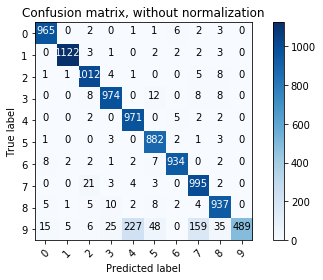

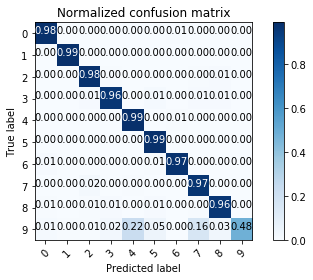

In [14]:
# Show confusion matrix
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)  # from one hot to class index
y_true = np.argmax(y_test, axis=1)  # from one hot to class index
show_matrix(y_true, y_pred, [i for i in range(10)])

## 1-3. Undersampling

In [68]:
# 正例の数を保存
positive_count_train = list(y_train).count(9)
print(positive_count_train)

49


In [69]:
x_train = x_train.reshape(len(x_train), 28*28)
print(x_train.shape)

(54100, 784)


In [70]:
# 正例が10％になるまで負例をダウンサンプリング
rus = RandomUnderSampler(ratio={
    0:positive_count_train*9,
    1:positive_count_train*9,
    2:positive_count_train*9,
    3:positive_count_train*9,
    4:positive_count_train*9,
    5:positive_count_train*9,
    6:positive_count_train*9,
    7:positive_count_train*9,
    8:positive_count_train*9,
    9:positive_count_train}, random_state=0)

# 学習用データに反映
x_train_resampled, y_train_resampled = rus.fit_sample(x_train, y_train)

In [71]:
print(x_train_resampled.shape, y_train_resampled.shape)

(4018, 784) (4018,)


In [72]:
x_train = x_train_resampled.reshape(len(x_train_resampled), 28, 28)
y_train = y_train_resampled
x_train.shape

(4018, 28, 28)

In [73]:
# Preprocess
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)
x_train, y_train = preprocess_input(x_train, y_train)
x_test, y_test = preprocess_input(x_test, y_test)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(4018, 28, 28, 1) (4018, 10) (10000, 28, 28, 1) (10000, 10)


In [79]:
# Build and train model
model = Model2D(input_shape=input_shape, num_classes=num_classes)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size)

Train on 4018 samples, validate on 10000 samples
Epoch 1/2
4018/4018 [==============================] - 1s 206us/step - loss: 1.2338 - acc: 0.6257 - val_loss: 0.5597 - val_acc: 0.8243
Epoch 2/2
4018/4018 [==============================] - 0s 85us/step - loss: 0.4593 - acc: 0.8599 - val_loss: 0.3770 - val_acc: 0.8722


Confusion matrix, without normalization
[[ 949    0   12    2    0    0    7    3    7    0]
 [   0 1111    7    3    2    0    4    0    8    0]
 [   6    2  951   19    8    0    6   21   19    0]
 [   1    1   36  940    0    4    0   17   11    0]
 [   1    3    3    1  958    0    8    5    2    1]
 [   7    2    1   39    2  805   17    2   17    0]
 [  14    6    3    1    7   14  909    0    4    0]
 [   2   10   25   11    7    1    0  967    0    5]
 [  25    2   15   20    8    3   10   19  871    1]
 [  20   10   19   33  368   10    0  279    9  261]]
Normalized confusion matrix


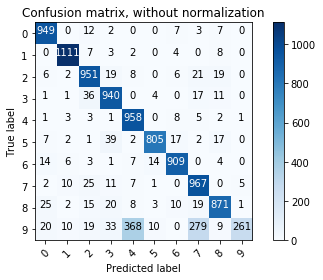

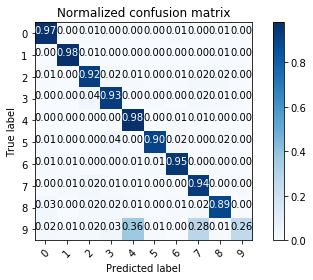

In [80]:
# Show confusion matrix
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)  # from one hot to class index
y_true = np.argmax(y_test, axis=1)  # from one hot to class index
show_matrix(y_true, y_pred, [i for i in range(10)])

## 2. Regression

In [161]:
def get_nearest(y_pred, num_classes=10):
    labels = np.array([i for i in range(num_classes)])
    idx = np.argmin(np.absolute(labels - y_pred), axis=1)
    return labels[idx]

In [214]:
def get_nearest_tensor(y_pred, num_classes=10):
    labels = np.array([i for i in range(num_classes)])
    idx = K.expand_dims(K.argmin(K.abs(labels - y_pred), axis=1), axis=-1)
    idx = tf.keras.backend.cast(idx, 'float32')
    return idx

In [215]:
# Build model
input_tensor = Input(shape=input_shape)
x = Conv2D(8, (3, 3), padding='same', activation='relu')(input_tensor)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(16, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
regression = Dense(1)(x)
model = Model(inputs=input_tensor, outputs=regression)
# classification = Lambda(get_nearest_tensor)(regression)
# model = Model(inputs=input_tensor, outputs=classification)

In [217]:
# Prepare data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000,) (10000, 28, 28, 1) (10000,)


In [218]:
# Build and train model
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size)

ValueError: An operation has `None` for gradient. Please make sure that all of your ops have a gradient defined (i.e. are differentiable). Common ops without gradient: K.argmax, K.round, K.eval.

Confusion matrix, without normalization
[[668 242  48  16   6   0   0   0   0   0]
 [107 915  90  18   5   0   0   0   0   0]
 [  0 324 578 106  18   6   0   0   0   0]
 [  0   4 494 445  57   9   1   0   0   0]
 [  0   0  11 299 532 115  21   4   0   0]
 [  0   0   8  73 460 324  26   1   0   0]
 [  0   1   3  22  95 464 365   8   0   0]
 [  0   0   9  16  41 138 572 241  11   0]
 [  0   0   1   6  20 106 265 394 175   7]
 [  0   0   0   9  17  34  65 180 511 193]]
Normalized confusion matrix


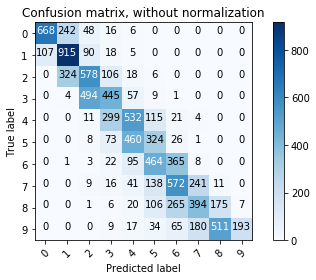

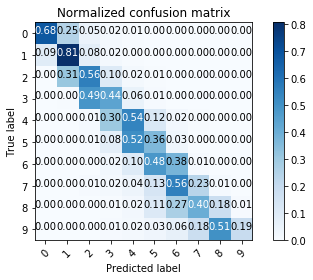

In [176]:
# Show confusion matrix
y_pred = get_nearest(model.predict(x_test))
show_matrix(y_test, y_pred, [i for i in range(10)])